### Взять временной ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import boxcox
import statsmodels.api as sm
import statsmodels.tsa.api as smt

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [37]:
dowjones_closing = pd.read_csv("./Series/weekly-closings-of-the-dowjones-.csv")
dowjones_closing_series = dowjones_closing["Close"]

# female_births = pd.read_csv("./Series/daily-total-female-births-in-cal.csv")
# female_births_series = female_births["Count"]

In [38]:
def test_stationarity(timeseries):
    '''Тест на стационарность временного ряда Дики-Фуллера'''
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    '''Визуализация (Оригинал, Автокорреляция, Частичная Автокорреляция)'''
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


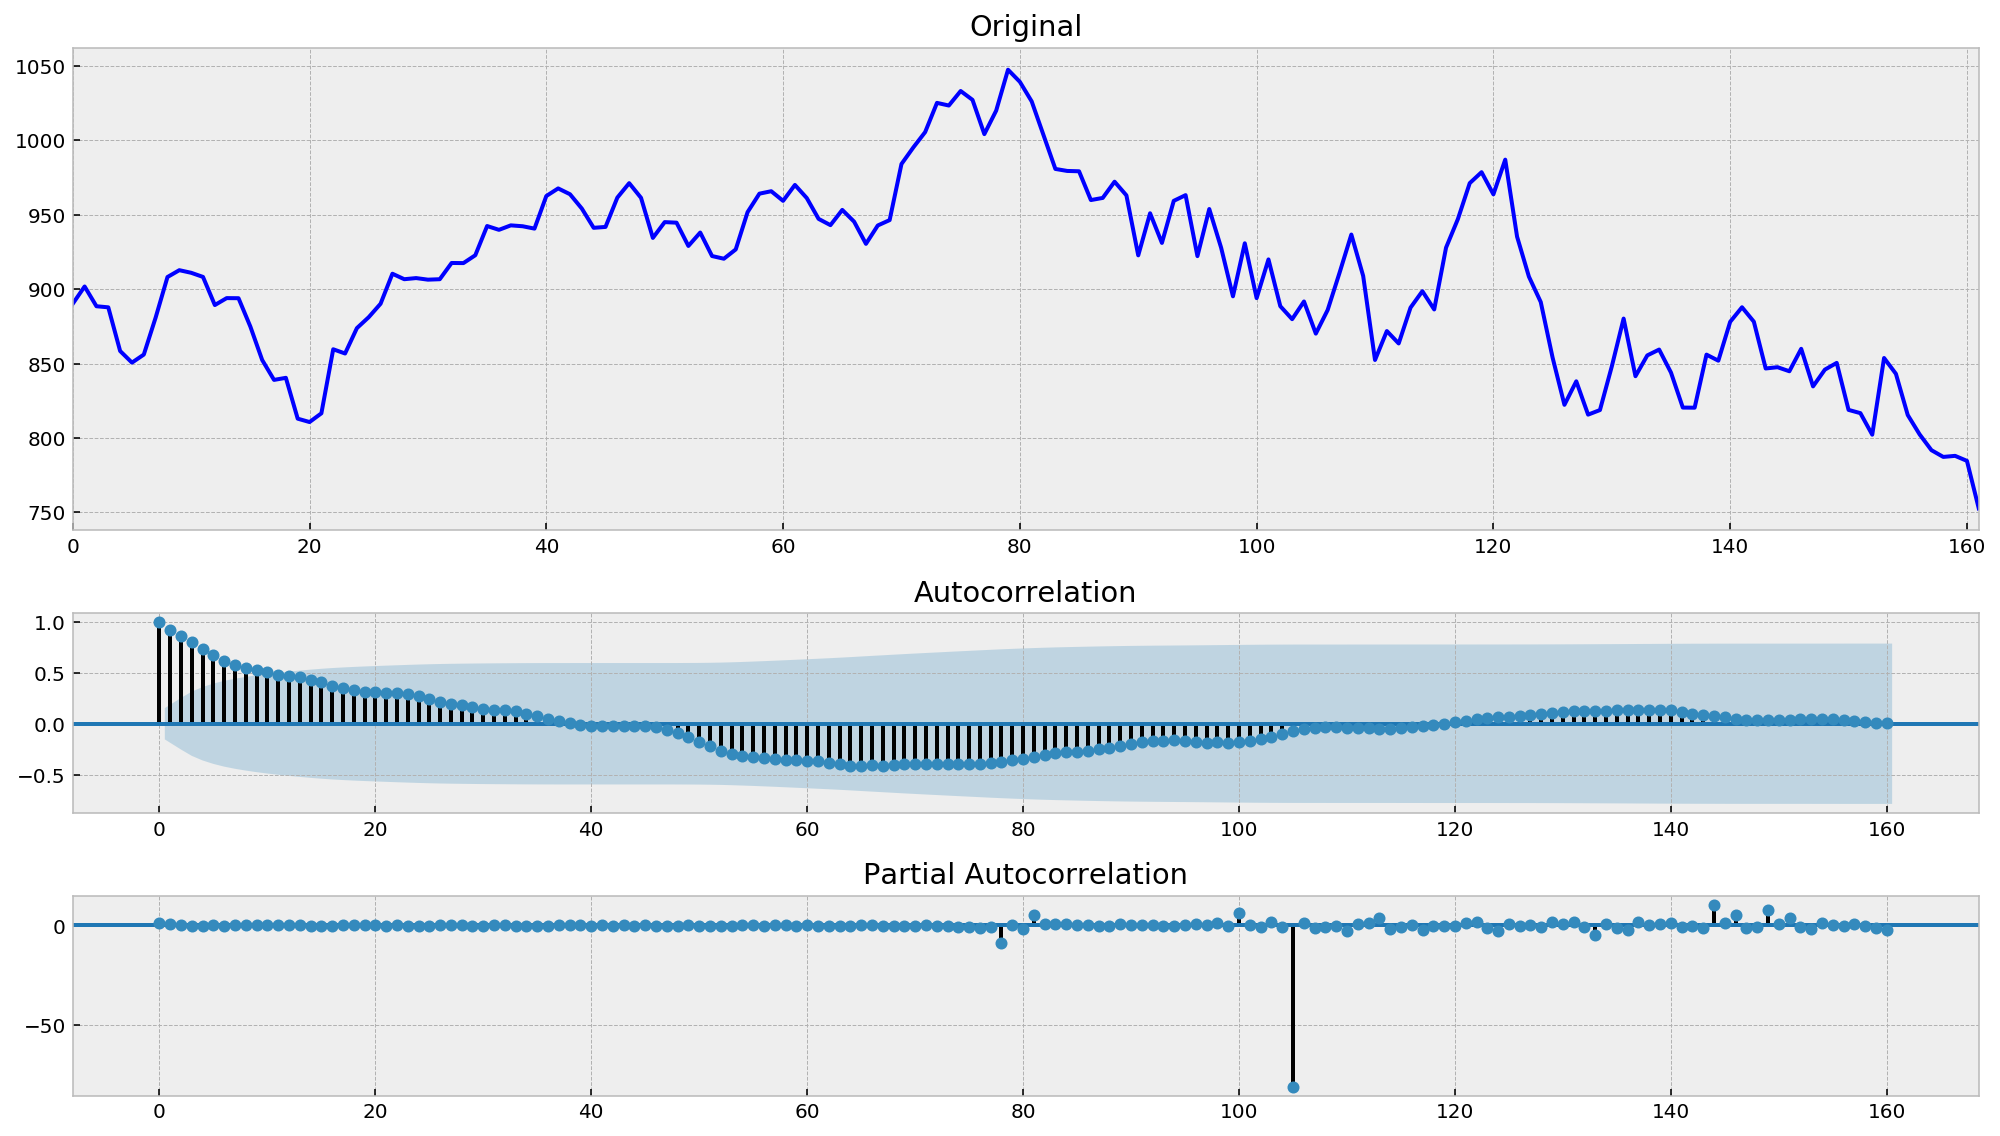

In [39]:
tsplot(dowjones_closing_series, lags=len(dowjones_closing_series)-2)

Как мы видим, и тест Дики-Фуллера и графики коррелограмм не отвергают гипотезу о нестационарности ряда. Для начала уберем изменение дисперсии при помощи преобразования Бокса-Кокса

In [40]:
series = boxcox(dowjones_closing_series, 0.5)

Results of Dickey-Fuller Test:
Test Statistic                  -1.263690
p-value                          0.645616
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


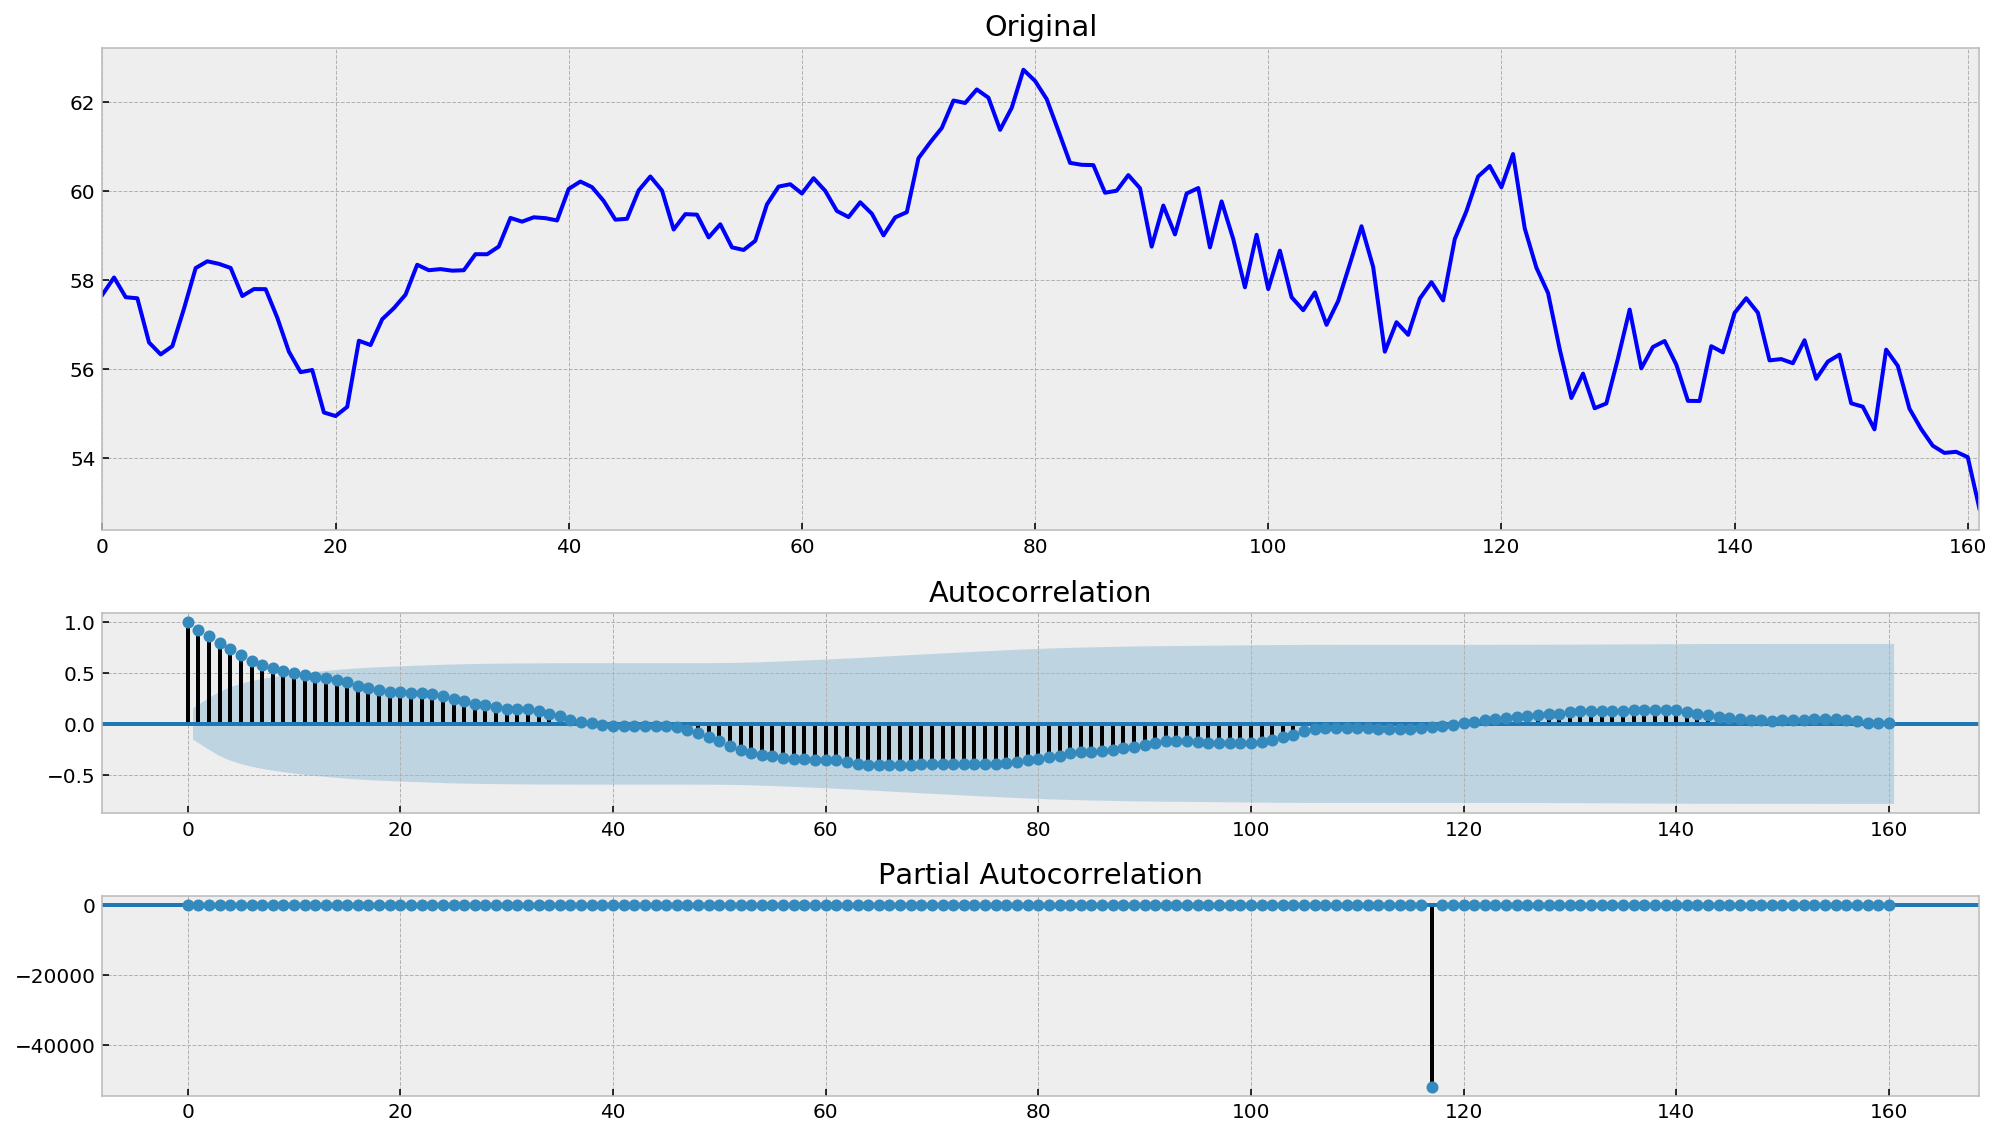

In [41]:
tsplot(series, lags=len(series)-2)

Нам удалось убрать размах дисперсии, но тест Дикки-Фуллера все еще не отвергает гипотезу о нестационарности ряда. По графику ряда видно наличие сильного тренда. Уберем его дифференцированием.

In [42]:
series_diff = np.diff(series, 1)

Results of Dickey-Fuller Test:
Test Statistic                -1.301319e+01
p-value                        2.542560e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


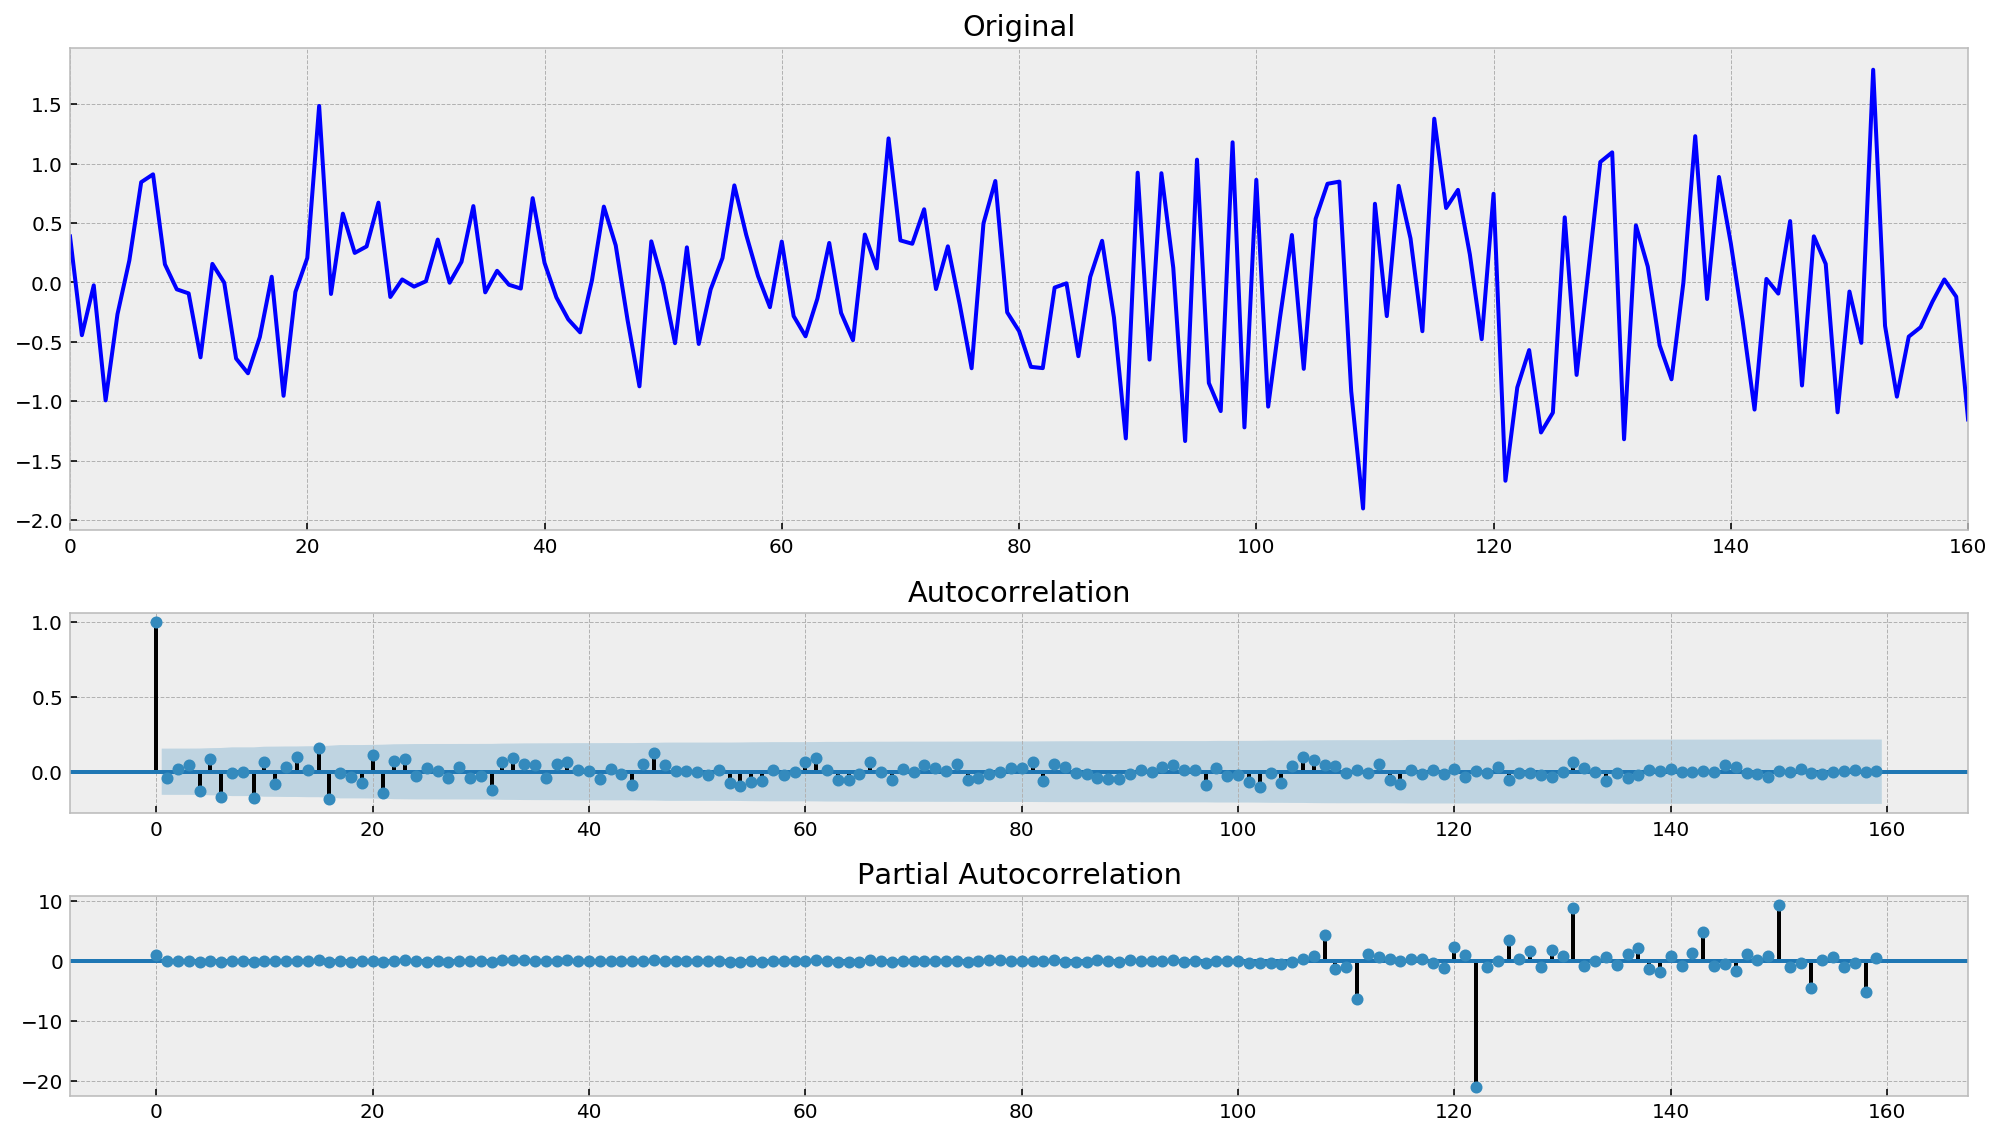

In [43]:
tsplot(series_diff, lags=len(series_diff)-2)

Теперь тест Дики-Фуллера и графики коррелограмм отвергают гипотезу о нестационарности ряда!

In [ ]:
pass

### Eсть два временных ряда, по одному набору данных:
    1. Нестационарный временной ряд - "series" (boxcox)
        - (p-value 0.645616) 
        - array([57.67210404, 58.05997003, 57.61576973, 57.59127453, 56.59795218,...])
    2. Стационарный временной ряд - "series_diff" (boxcox + diff)
        - (p-value 2.542560e-24)
        - array([ 0.38786599, -0.4442003 , -0.0244952 , -0.99332235, -0.26751416,...])

### Moving Average (MA)

In [72]:
def moving_average(series, n):
    '''Скользящее среднее'''
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()


def visualization_ma(series, stationary=False):
    '''Visualization Moving Average (MA)'''
    windows = [3,5,15,20,35]
    colors = ['red', 'green', 'purple', 'black', 'yellow']
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series, color='blue',label='original')
        for i in range(len(windows)):
            ser = moving_average(series, windows[i])
            plt.plot(ser, color=colors[i], linewidth='2', label='Moving Average {}'.format(windows[i]))    
        if stationary==False:
            plt.title('Нестационарный временной ряд - "series"')
            plt.legend()
        else:
            plt.title('Стационарный временной ряд - "series_diff"')
            plt.legend()

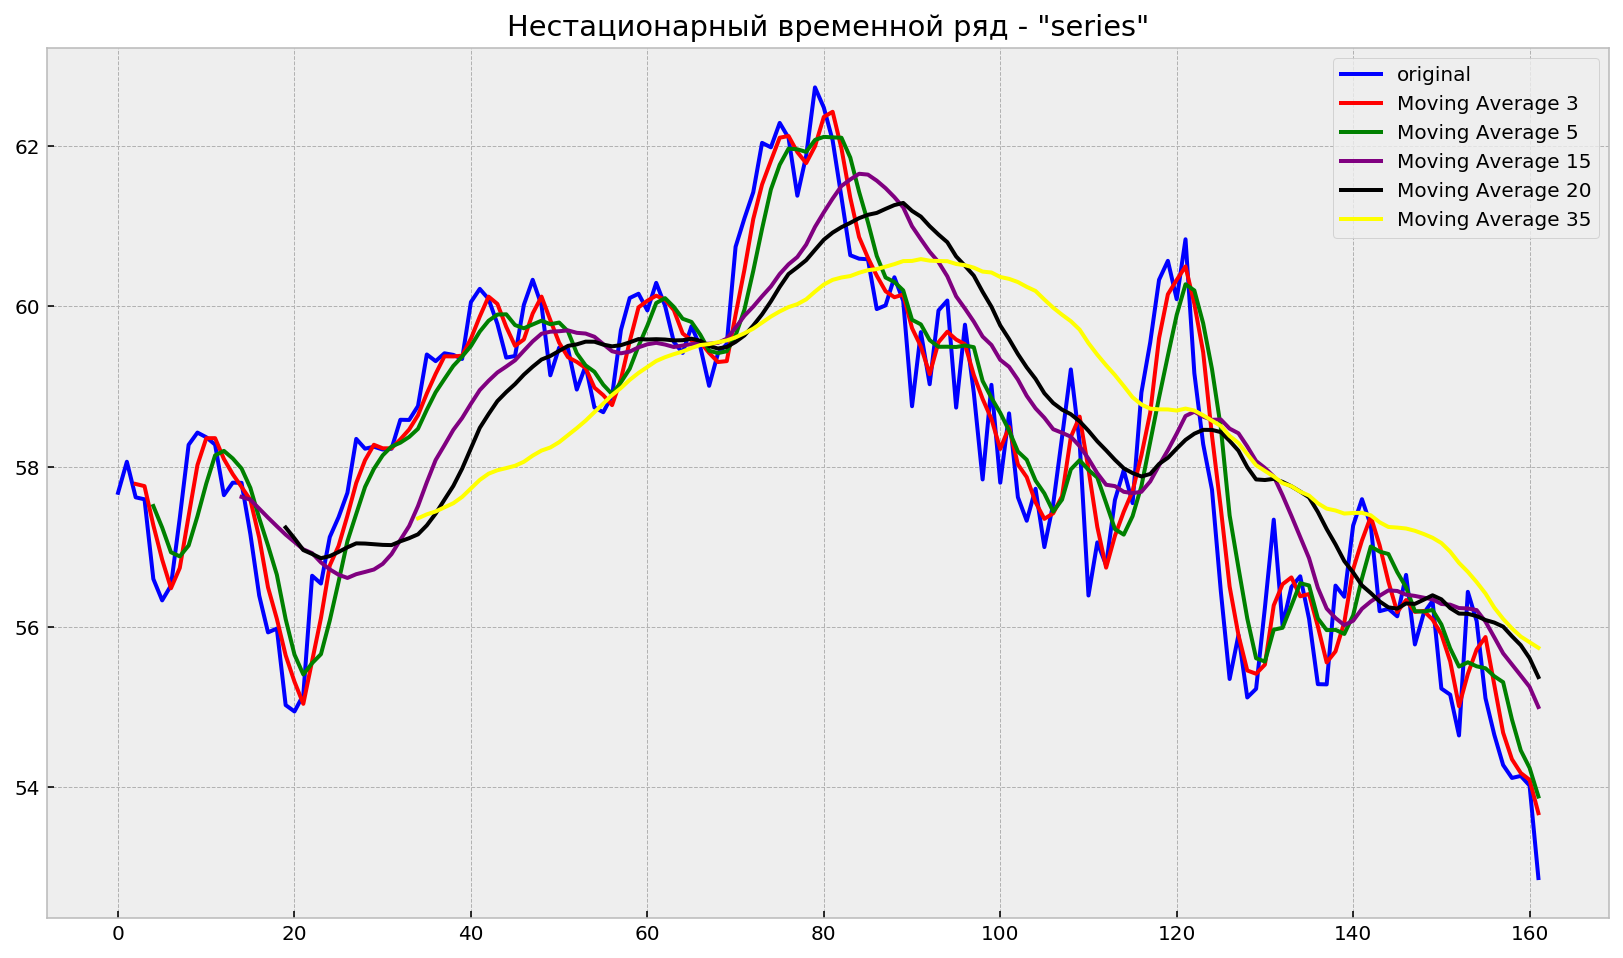

In [73]:
visualization_ma(series, stationary=False)

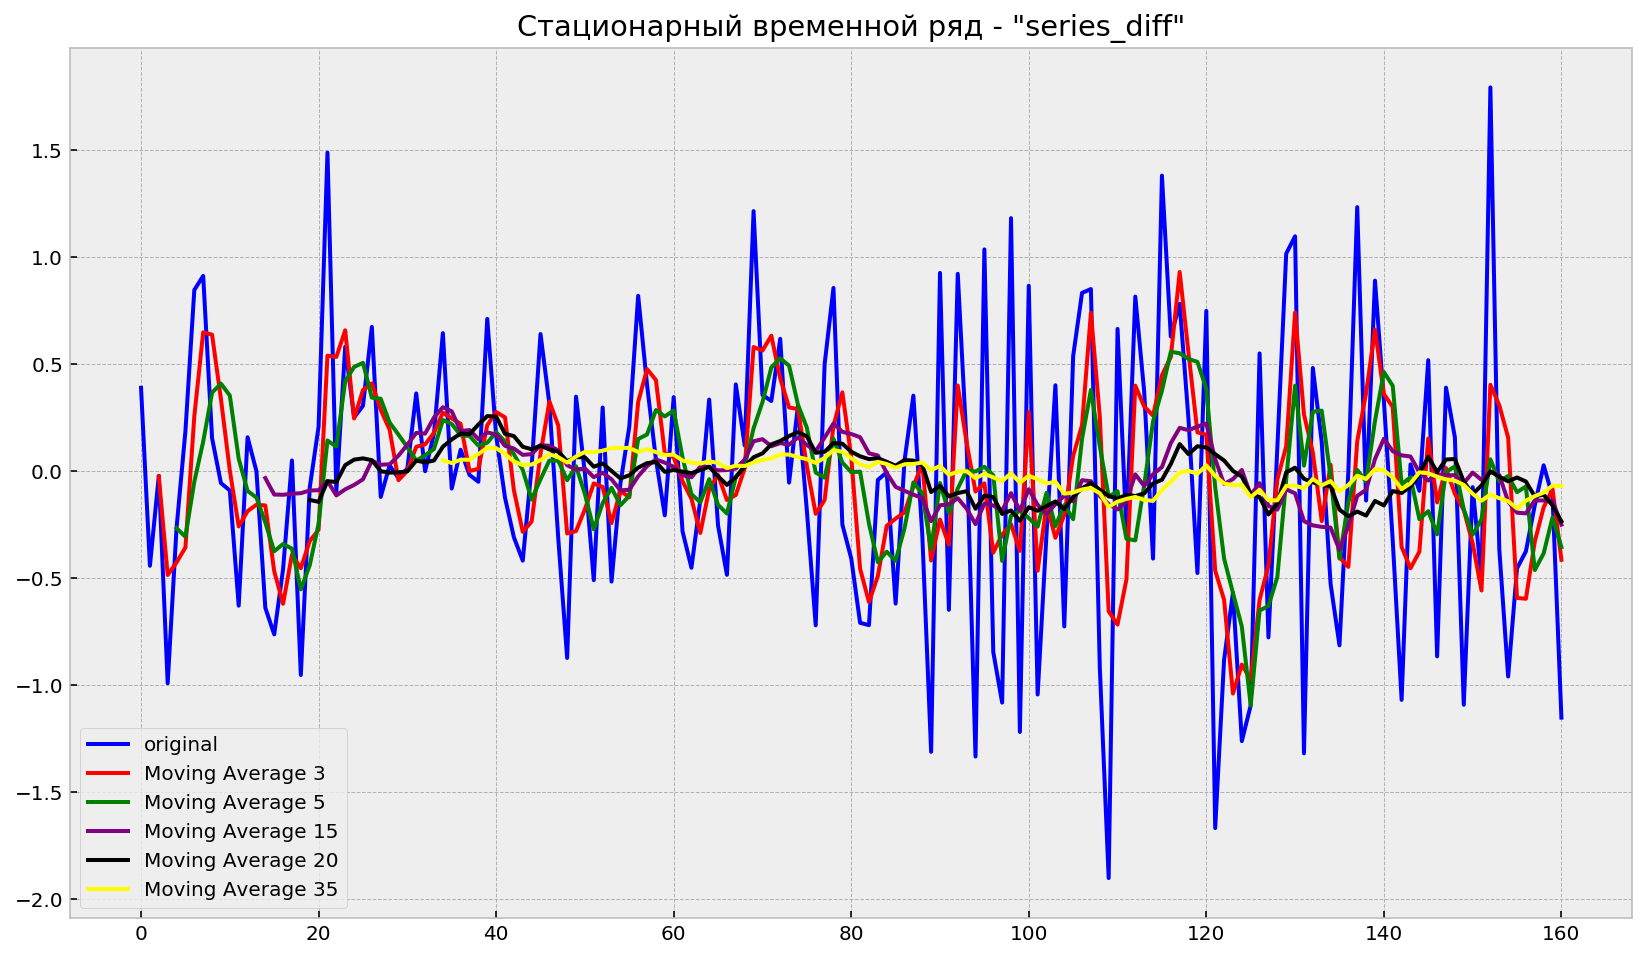

In [74]:
visualization_ma(series_diff, stationary=True)

- Чем больше размер "окна" скользящего среднего $n$ тем более сглаженным получается результат.
- По нескольким скользящим средним можно увидеть периоды резкого роста и резкого спада.
- Характерная особенность обычного скользящего среднего - повышенная чувствительность к выбросам данных.

### Weighted Moving Average (WMA)

In [100]:
def weighted_moving_average(series, n, weights):
    '''Модификацией обычной скользящей средней является взвешенная скользящая средняя'''
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return pd.Series([np.NaN]).append(wma, ignore_index=True)


def visualization_wma(series, stationary=False):
    '''
    Visualization Weighted Moving Average (WMA)
    wma_fib - последовательность Фибоначчи
    wma_seq - последовательность 
    wma_pow - возведение в степень (^2)
    '''
    wma_fib = weighted_moving_average(series, 7, [1,1,2,3,5,8,13])
    wma_seq = weighted_moving_average(series, 7, [1,2,3,4,5,6,7])
    wma_pow = weighted_moving_average(series, 7, [1,2,4,8,16,32,64])
    
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series, color='blue',linewidth='2', label='original')
        plt.plot(wma_fib, color='red', linewidth='2', label='Fibonacci')
        plt.plot(wma_seq, color='green', linewidth='2', label='Sequence')
        plt.plot(wma_pow, color='black', linewidth='2', label='Power (degree)')
    if stationary==False:
        plt.title('Нестационарный временной ряд - "series"')
        plt.legend()
    else:
        plt.title('Стационарный временной ряд - "series_diff"')
        plt.legend()

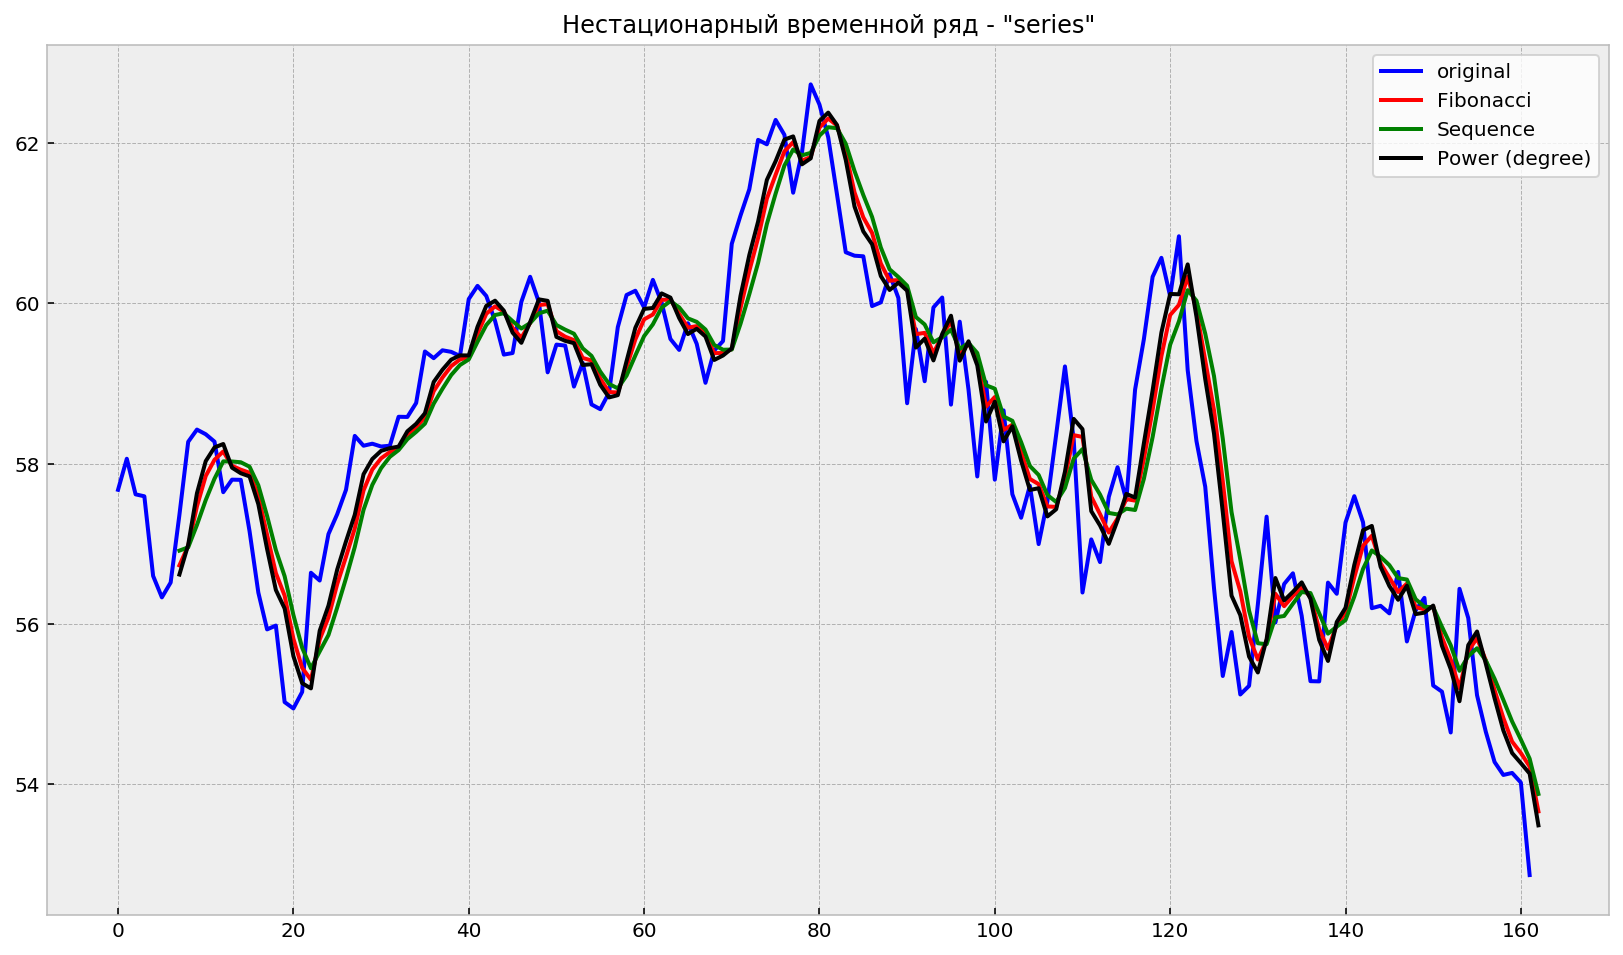

In [101]:
visualization_wma(series, stationary=False)

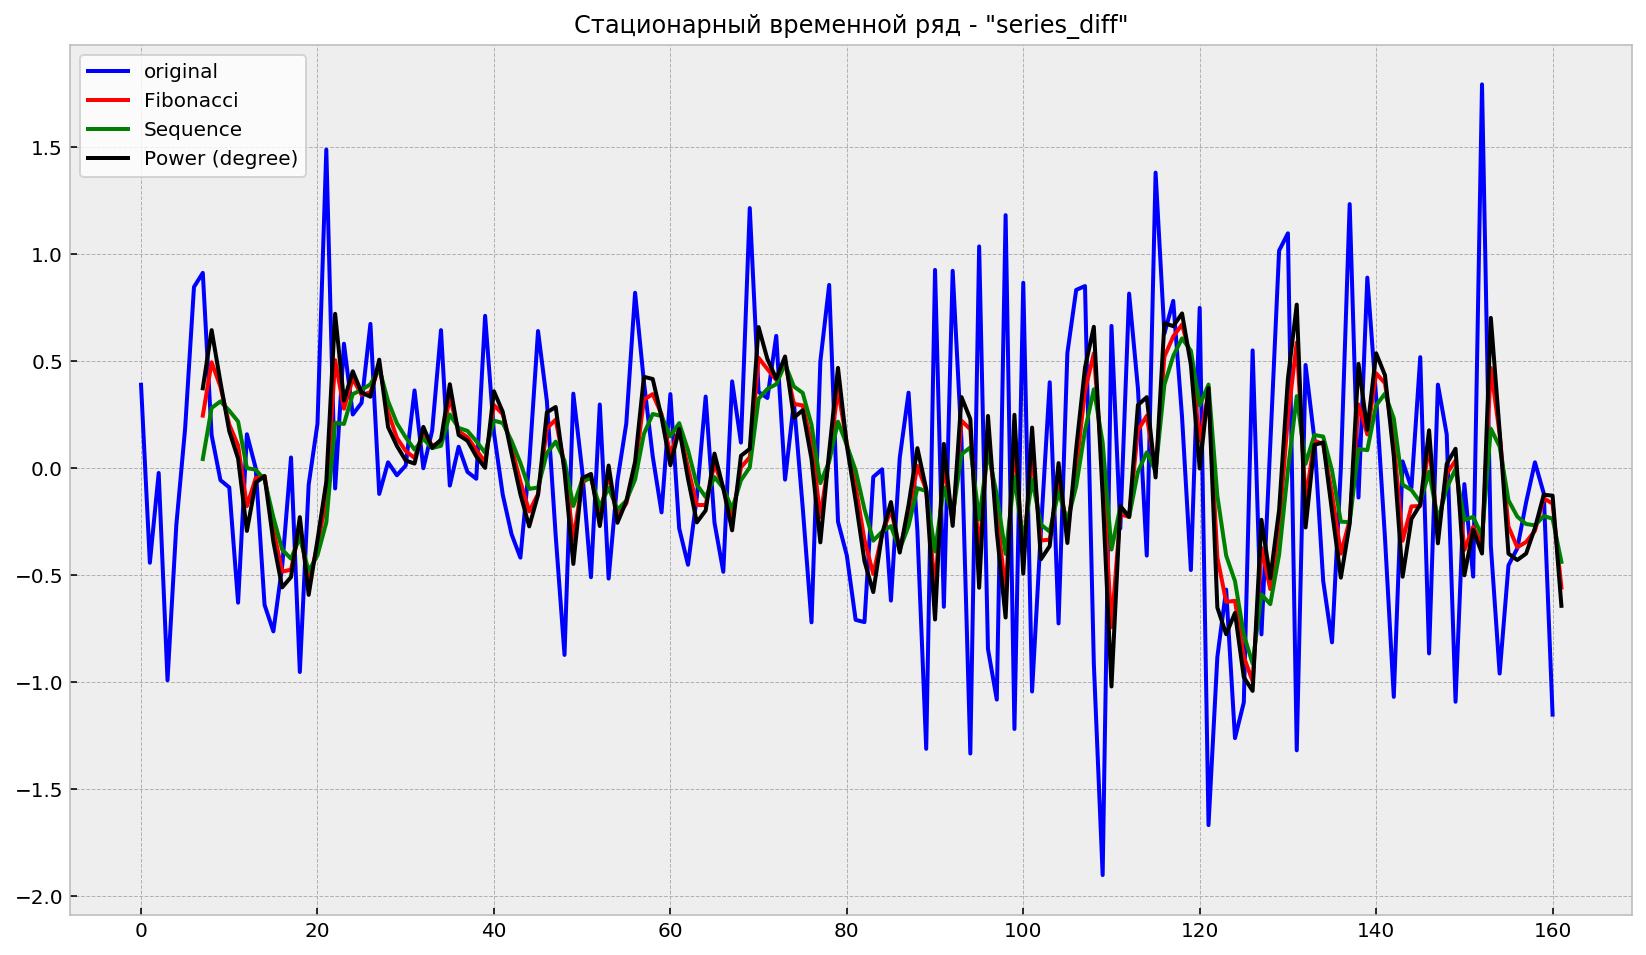

In [102]:
visualization_wma(series_diff, stationary=True)

- Обычно чем ближе измерение к прогнозируемому - тем больше его вес.
- WMA не уловила экстремумы ($\min$, $\max$) и дисперсию в ряде, что показывает непригодность к использованию на данном наборе данных.

### Exponential Moving Average (EMA)

In [103]:
def exponential_moving_average(series, alpha):
    '''Экспоненциальное сглаживание'''
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)


def visualization_EMA(series, stationary=False):
    alphas = [0.05,0.1,0.3,0.8]
    colors = ['red', 'green', 'purple', 'black']
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series, color='blue',label='original')
        for i in range(len(alphas)):
            ser = exponential_moving_average(series, alphas[i])
            plt.plot(ser, color=colors[i], linewidth='2', label='EMA {}'.format(alphas[i]))
    if stationary==False:
        plt.title('Нестационарный временной ряд - "series"')
        plt.legend()
    else:
        plt.title('Стационарный временной ряд - "series_diff"')
        plt.legend()

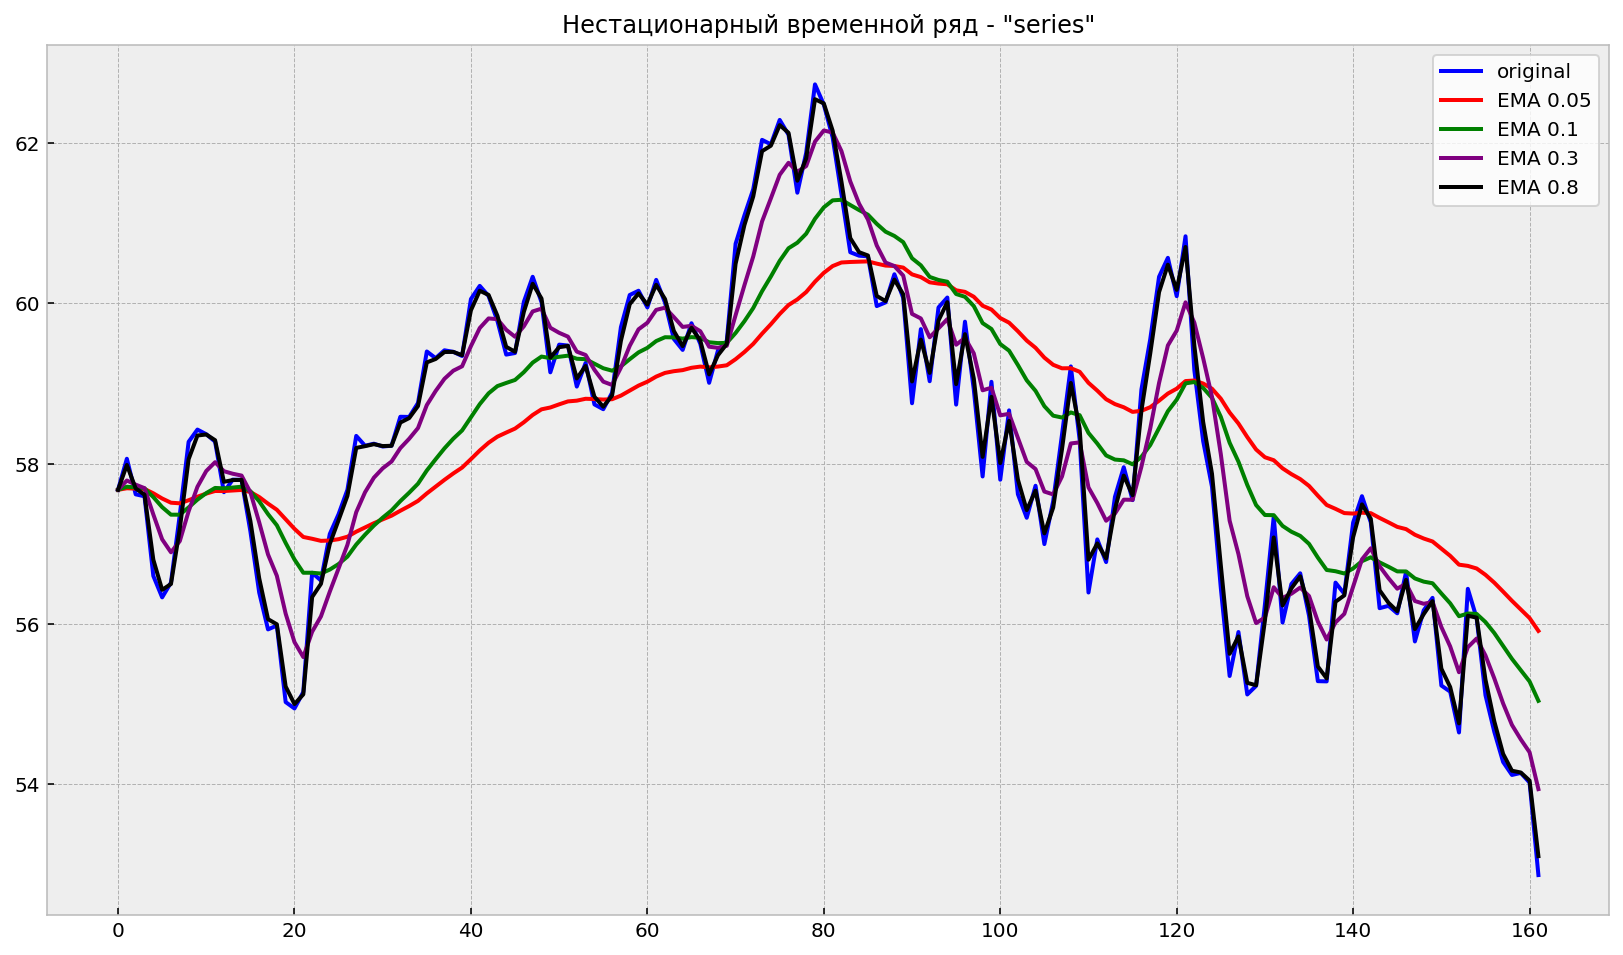

In [105]:
visualization_EMA(series, stationary=False)

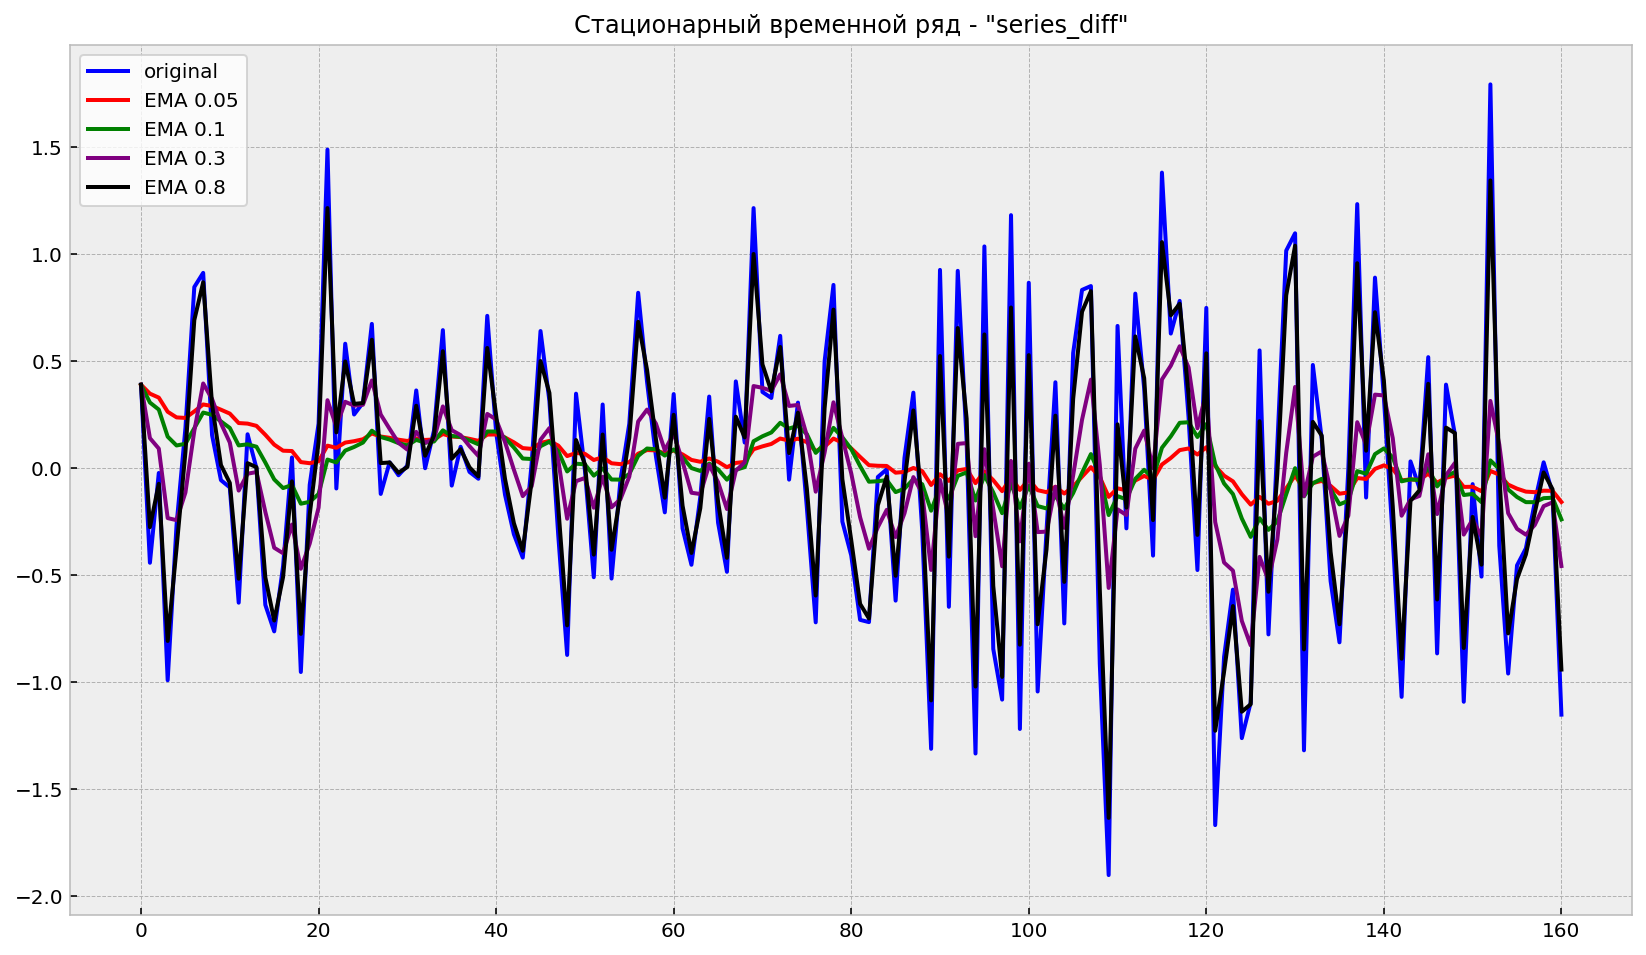

In [106]:
visualization_EMA(series_diff, stationary=True)

- Видно что EMA для нашего временного ряда "series_diff" дала наилучший результат при параметре $\alpha$=0.8

### Double Exponential Moving Average (DEMA)

In [133]:
def double_ema(series, alpha, beta):
    '''Двойное экспоненциальное сглаживание'''
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)


def visualization_dema(series, stationary=False):
    alpha = [0.05,0.1,0.3,0.8]
    beta = [0.2,0.8,0.2,0.8]
    color = ['red', 'green', 'purple', 'black']
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series, color='blue',label='original')
        for i in range(len(alpha)):
            dema = double_ema(series, alpha[i], beta[i])
            plt.plot(dema, color=color[i], linewidth='2', alpha=0.5, label='DEMA {} {}'.format(alpha[i], beta[i]))
    if stationary==False:
        plt.title('Нестационарный временной ряд - "series"')
        plt.legend()
    else:
        plt.title('Стационарный временной ряд - "series_diff"')
        plt.legend()

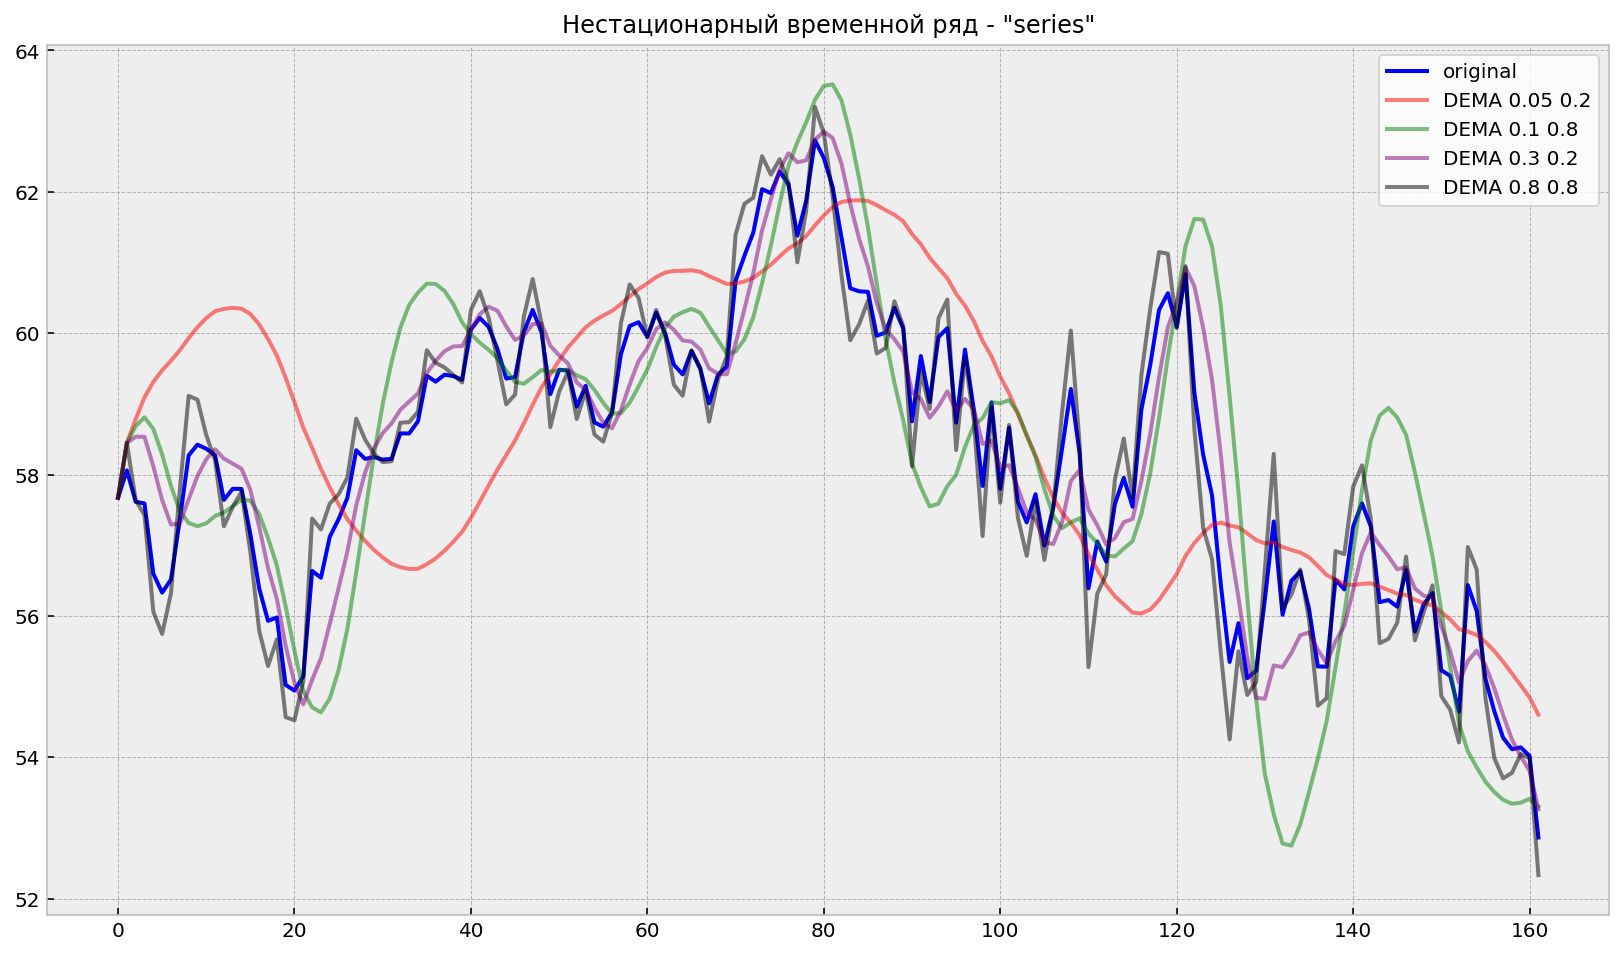

In [134]:
visualization_dema(series, stationary=False)

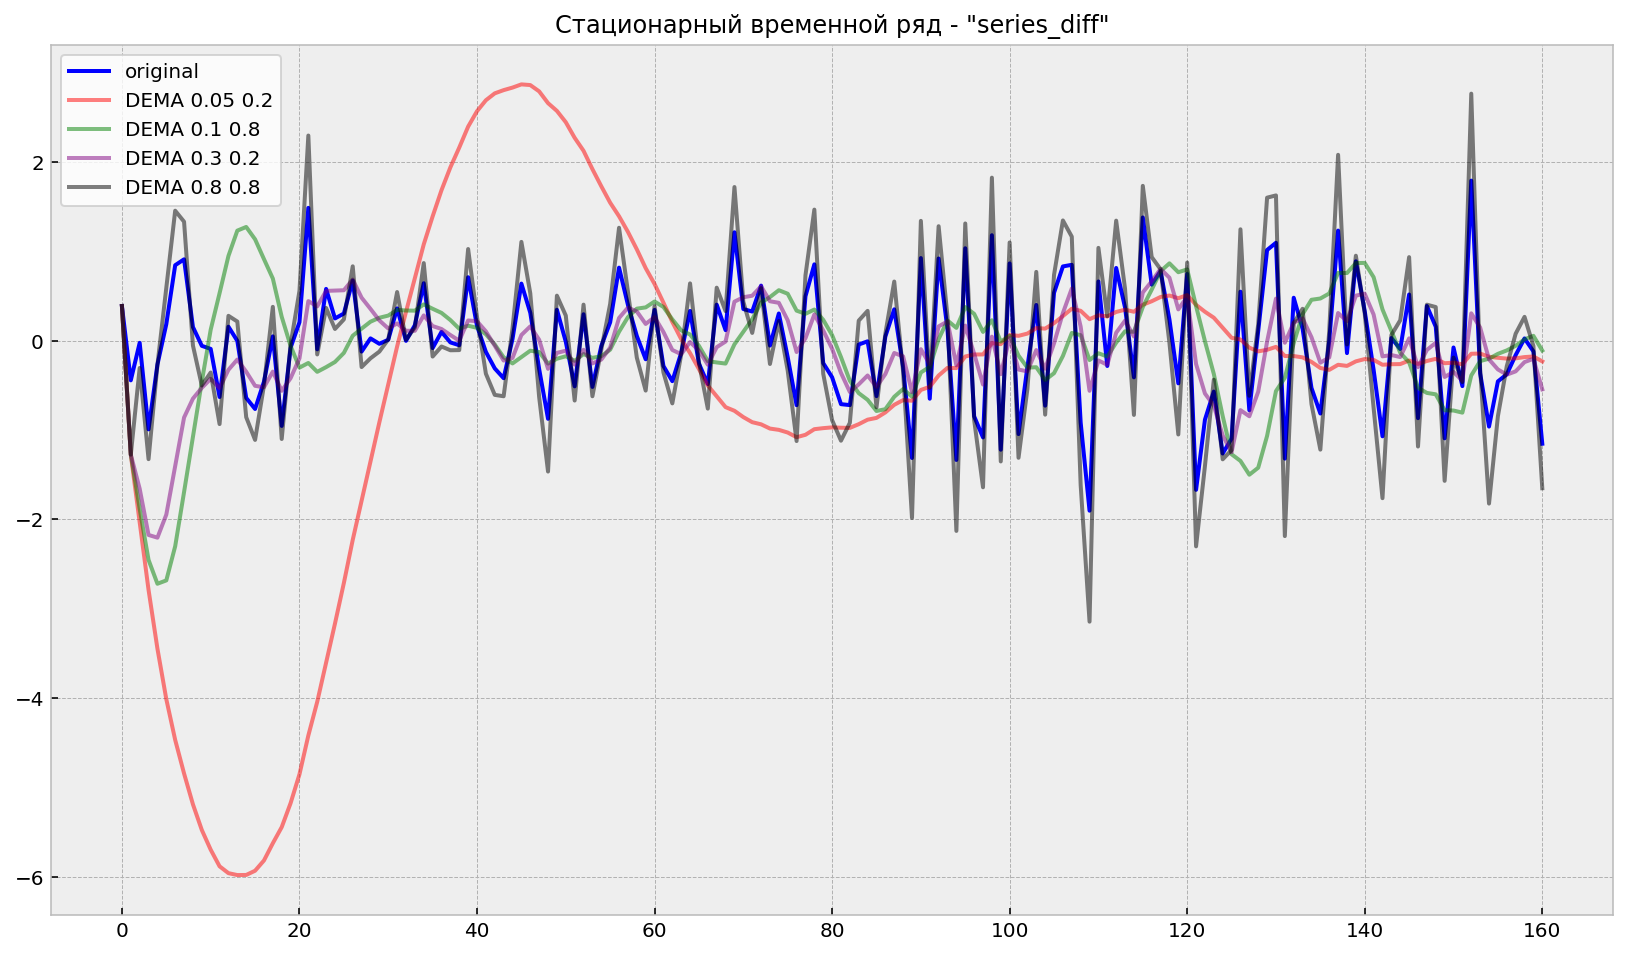

In [135]:
visualization_dema(series_diff, stationary=True)

- Большая чувствительность к парамметрам $\alpha$ и $\beta$
- Лучший вариант получился при пересечении значений $\alpha$ и $\beta$

_(Как мы видим, настройка параметров $\alpha$ и $\beta$ может порой давать самые причудливые результаты. $\alpha$ отвечает за сглаживание ряда вокруг тренда, $\beta$ - за сглаживание самого тренда. Чем больше значения, тем более значимыми будут последние наблюдения и менее значимой будет история.)_

### Тройное экспоненциальное сглаживание a.k.a. Holt-Winters (TEMA)

In [145]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len


def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals


def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0:
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series):
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result


def visualization_tema(series, n_preds=0, stationary=False):
    alpha = [0.1,0.6,0.1]
    beta = [0.1,0.7,0.1]
    gamma = [0.2,0.8,0.1]
    color = ['red', 'green', 'purple', 'black']
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series, color='blue',label='original')
        for i in range(len(alpha)):
            tema = triple_exponential_smoothing(series, 12, alpha[i], beta[i], gamma[i],  n_preds)
            plt.plot(tema, color=color[i], linewidth='2', alpha=0.5, label='TEMA {} {} {}'.format(
                alpha[i], beta[i], gamma[i]))
    if stationary==False:
        plt.title('Нестационарный временной ряд - "series"')
        plt.legend()
    else:
        plt.title('Стационарный временной ряд - "series_diff"')
        plt.legend()

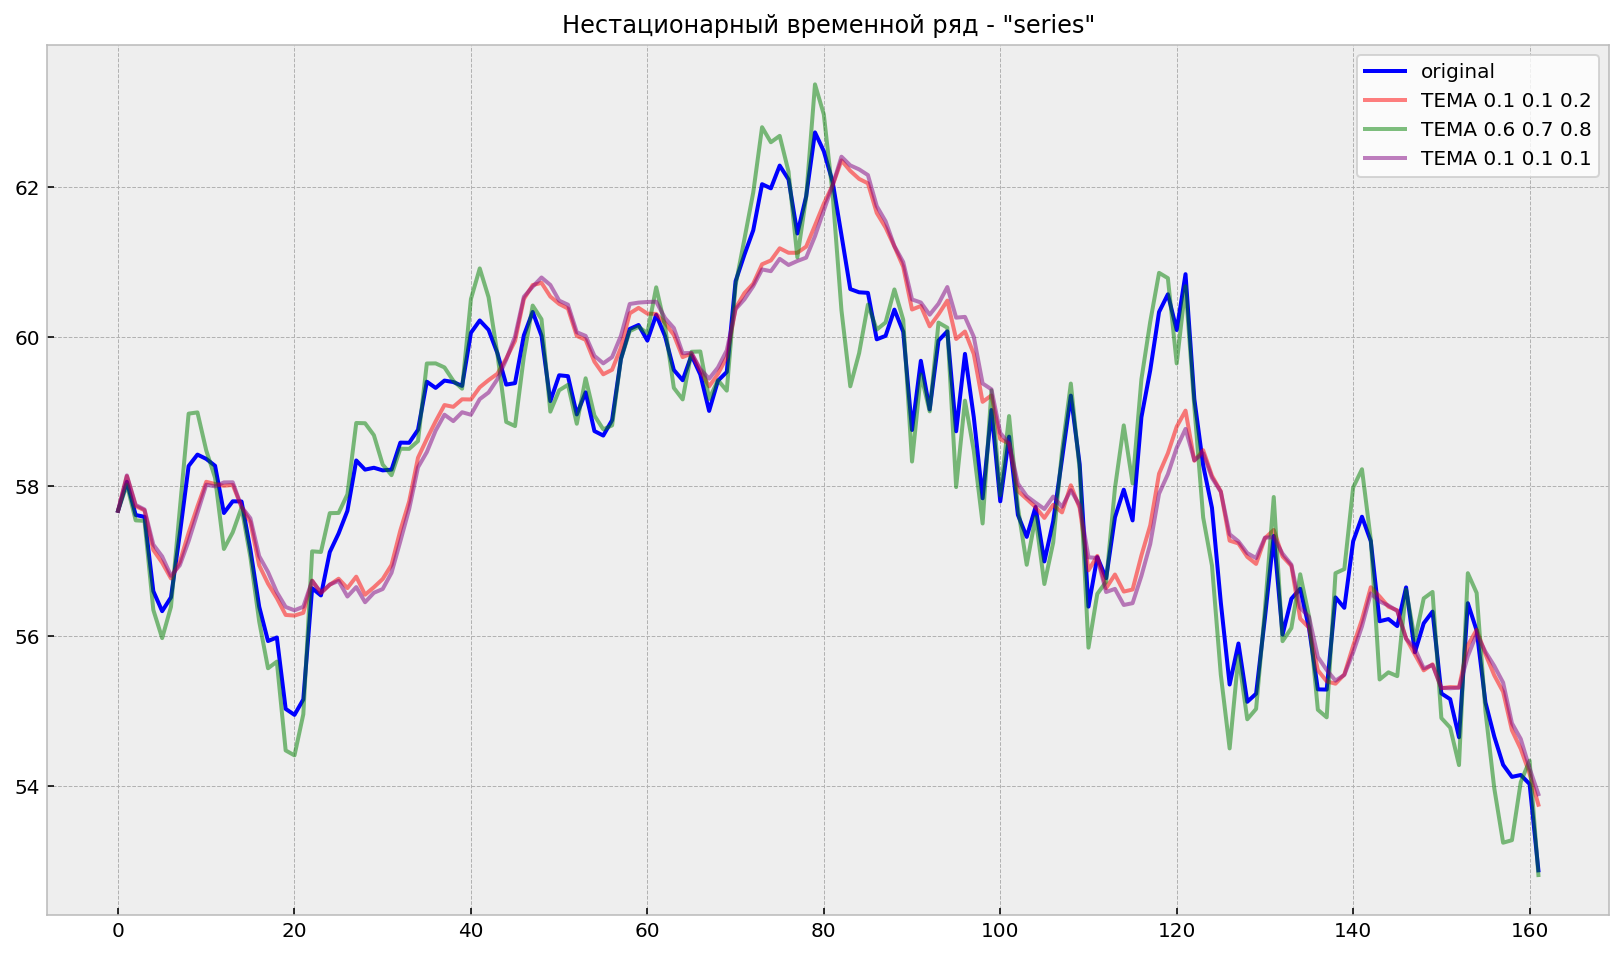

In [193]:
visualization_tema(series, n_preds=0, stationary=False)

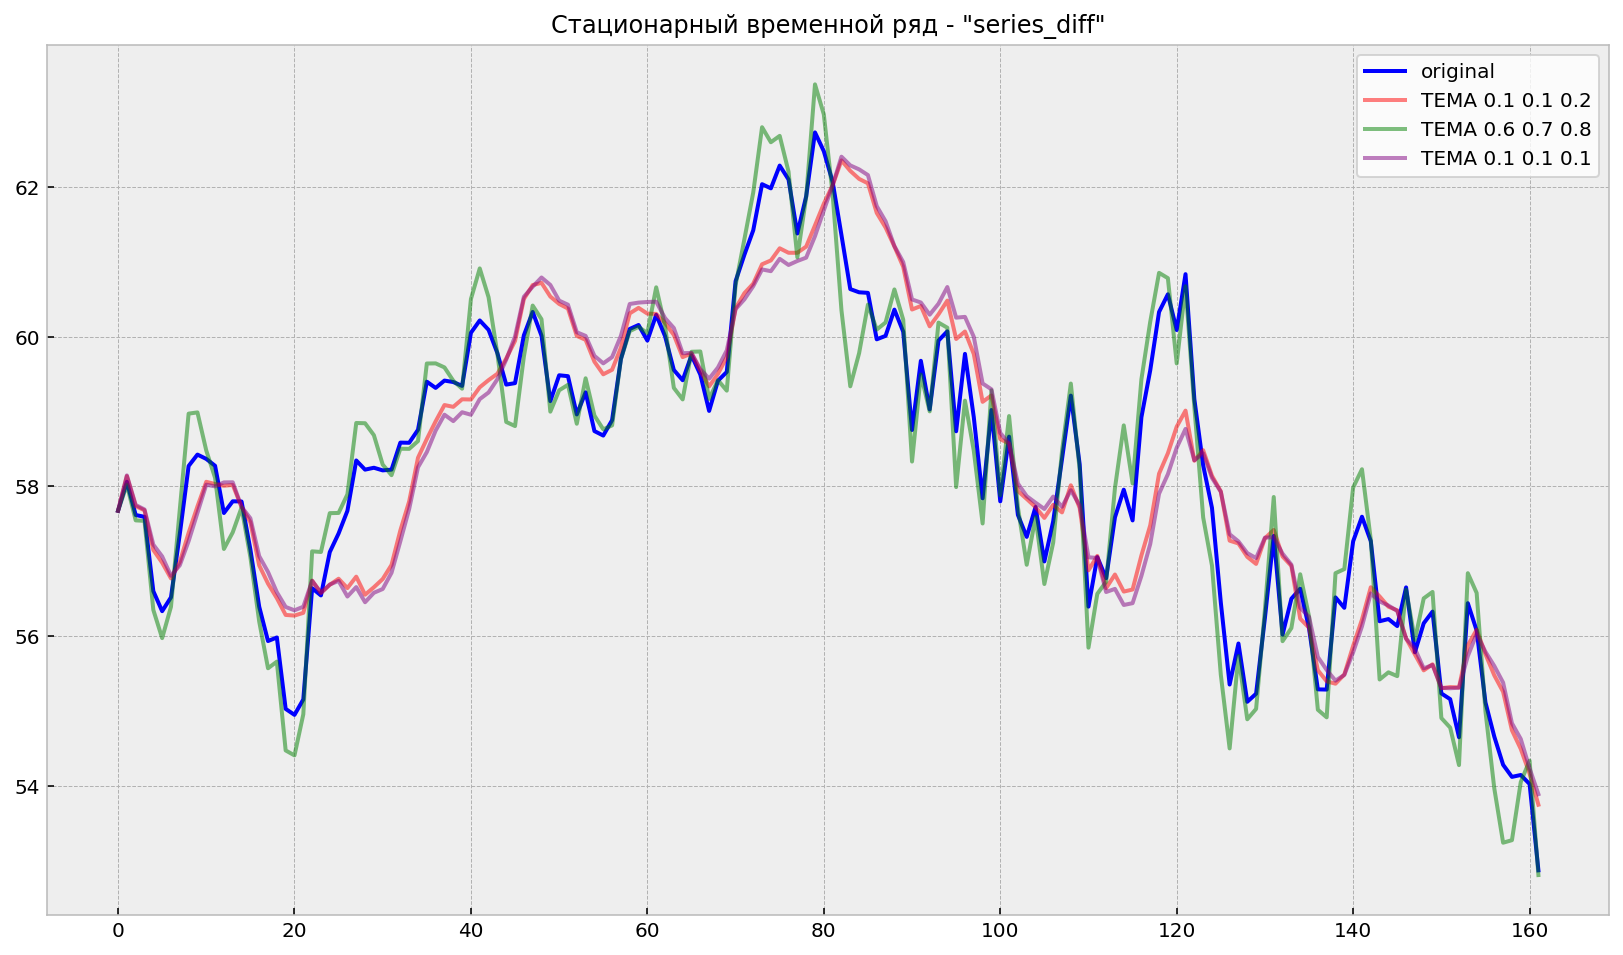

In [194]:
visualization_tema(series, n_preds=0, stationary=True)

### Попробуем предсказать временной ряд:
- Разделим наши данные на test и val
- Применим minimize и mse_cross_val
- Визуализируем результаты

In [189]:
def plot_tema(alpha, beta, gamma, ser, ser_to_plot, n_preds, stationary=False):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA', alpha=0.5)
        if stationary==False:
            plt.title('Нестационарный временной ряд - "series"\nalpha={}, beta={}, gamma={}'.format(alpha, beta, gamma))
            plt.legend()
        else:
            plt.title('Стационарный временной ряд - "series_diff"\nalpha={}, beta={}, gamma={}'.format(alpha, beta, gamma))
            plt.legend()
        
        
def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    for train_split, test_split in split.split(train):
        result = triple_exponential_smoothing(train_split, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)
    return np.mean(np.array(errors))


def predict_tema(series, num=len(series)-20, stationary=False):
    train, val = series[:num], series[num:]
    opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds=((0, 1), (0, 1), (0, 1)))
    alpha_opt, beta_opt, gamma_opt = opt.x
    print(opt)
    if stationary==False:
        plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val), stationary=False)
    else:
        plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=series, n_preds=len(val), stationary=True)

      fun: 4.167328257007146e-08
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.33302149e-05,  9.31485775e-06, -6.29358954e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 328
      nit: 67
   status: 0
  success: True
        x: array([0.04227352, 0.26106462, 0.97151739])


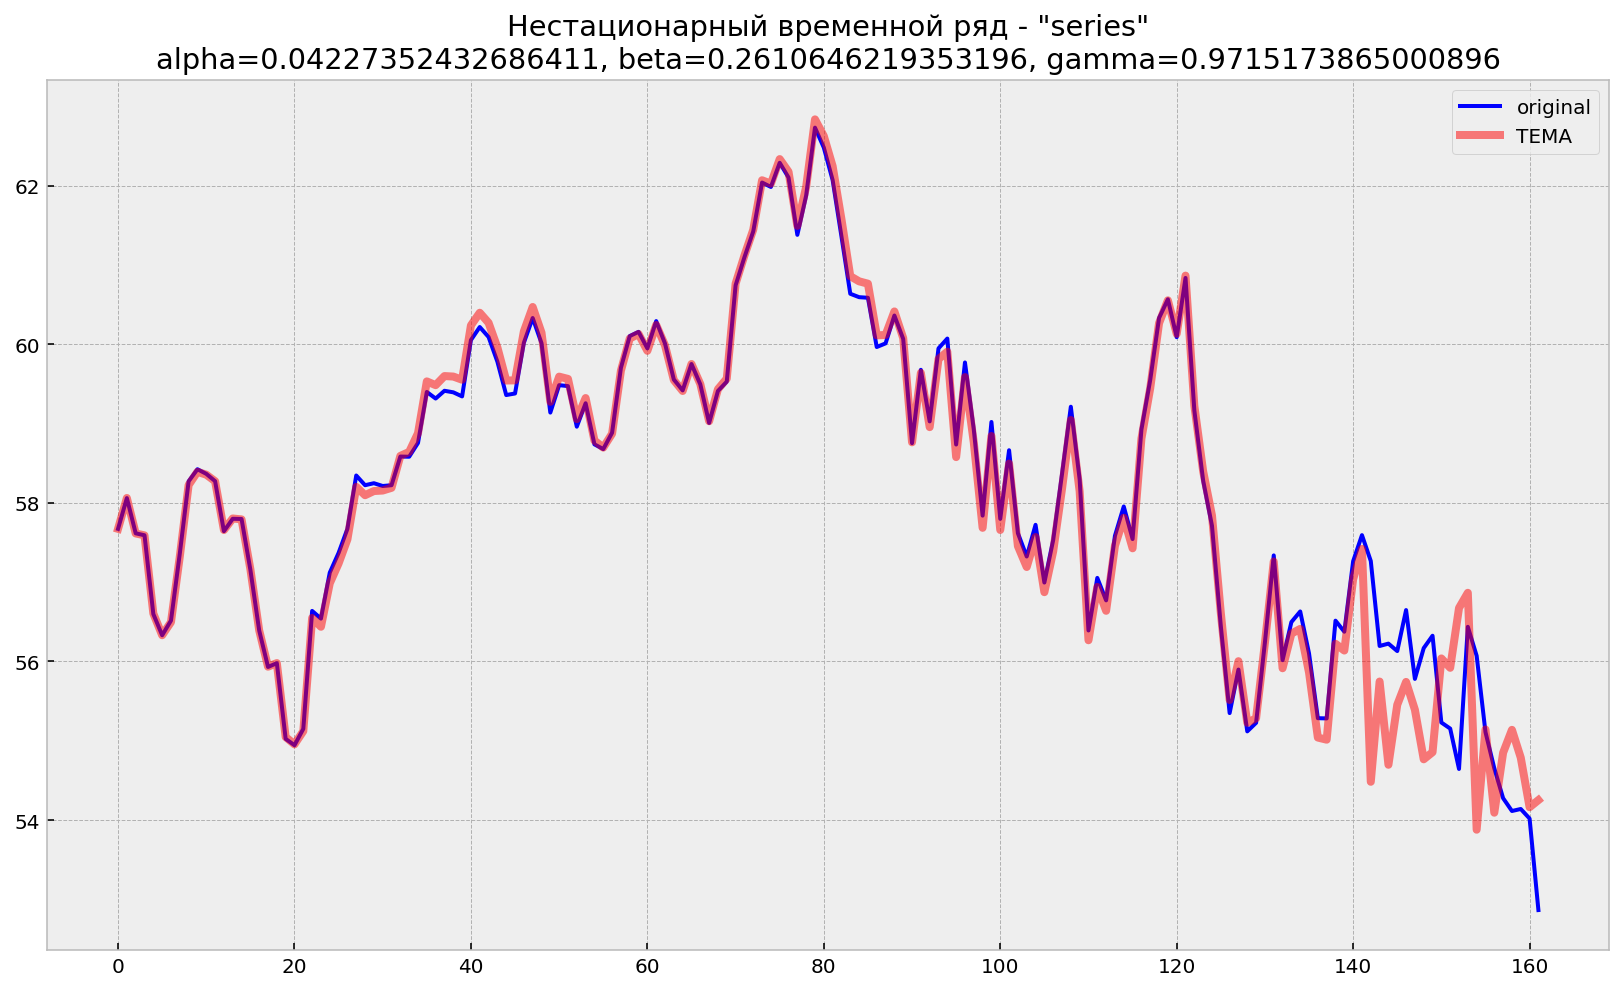

In [190]:
predict_tema(series, stationary=False)

      fun: 4.167328257007146e-08
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.33302149e-05,  9.31485775e-06, -6.29358954e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 328
      nit: 67
   status: 0
  success: True
        x: array([0.04227352, 0.26106462, 0.97151739])


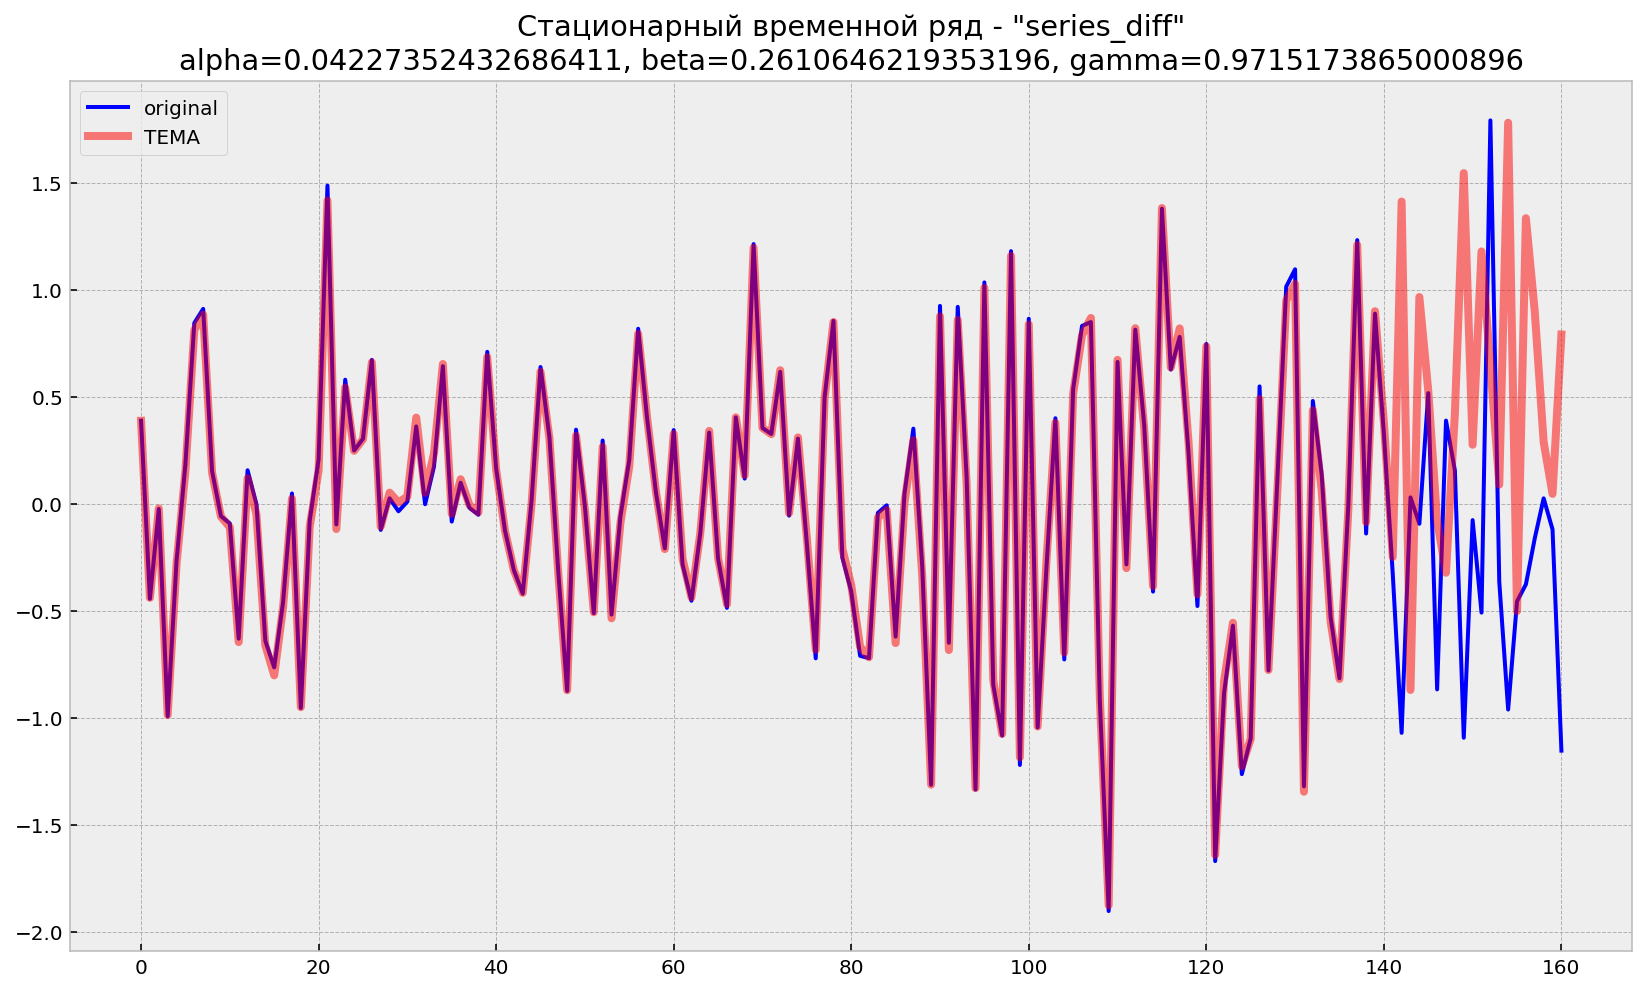

In [191]:
predict_tema(series_diff, stationary=True)

**Нестационарная модель**:
 - Дисперсия сдвинута + в результате получаем непостоянство ковариаций
 - Если изучить график то есть приблизительное совпадение с экстремумом прогнозной модели по $\max$, но по прежнему плохо
 
**Стационарная модель**:
 - Словила тренд, прогноз выглядит ужасно (получаем, что матожидание со временем растёт)

**Дополнительно по работе в целом**:
  - Вариант применять более сложные преобразования (ARIMA/SARIMA)
  - Пробывать глубокое обучение (наиболее интересный вариант)

In [ ]:
pass

_Интересные статьи:_
- [Анализ временных рядов с помощью Python](https://habr.com/ru/company/ods/blog/327242/)
- [Сравнение моделей временных рядов](https://basegroup.ru/community/bank/compare-model)
- [Triple Exponential Smoothing](https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc435.htm)
- [Holt-Winters Forecasting for Dummies (or Developers)](https://grisha.org/blog/2016/01/29/triple-exponential-smoothing-forecasting/)

_Полезные ресурсы:_
- [Open Machine Learning Course. Topic 9. Part 1. Time series analysis in Python](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3)
- [Видеозапись](https://youtu.be/nQjul-5_0_M) лекции по мотивам статьи [Анализ временных рядов с помощью Python](https://habr.com/ru/company/ods/blog/327242/)
- [Open Machine Learning Course. Topic 9. Part 2. Predicting the future with Facebook Prophet](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-part-3-predicting-the-future-with-facebook-prophet-3f3af145cdc)
- [Онлайн-учебник](https://people.duke.edu/~rnau/411home.htm) курса по продвинутому статистическому прогнозированию университета Duke — разобраны всевозможные сглаживания, линейные модели и ARIMA модели
- Статья [Comparison of ARIMA and Random Forest time series models for prediction of avian influenza H5N1 outbreaks](http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016) — одна из немногих, где активно защищается позиция случайного леса в задачах по прогнозированию временных рядов
- Статья [Time Series Analysis (TSA) in Python — Linear Models to GARCH](http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016) семействе моделей ARIMA и их применении для моделирования финансовых показателей (Brian Christopher)